## Implement MNIST model from scratch using NumPy
Idea and some code from: https://github.com/geohot/ai-notebooks/blob/master/mnist_from_scratch.ipynb

#### PyTorch Implementation

In [255]:
import pandas as pd
import math
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline

In [236]:
# Load the mnist dataset and rescale images to 0-1
def fetch(url):
    import requests, gzip, os, hashlib, numpy
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28)) / 255.0
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28)) / 255.0
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [237]:
# First implement in PyTorch
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = torch.nn.Linear(784, 64, bias=False)
        self.layer2 = torch.nn.Linear(64, 10, bias=False)
        #self.softmax = torch.nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = torch.nn.functional.relu(self.layer1(x))
        x = self.layer2(x)
        #x = self.softmax(x)
        return x

In [238]:
# Pre-training definitions
model = Net()
batch_size = 128
loss_fun = torch.nn.CrossEntropyLoss()
opt = torch.optim.SGD(model.parameters(), lr=0.1)

losses = []
accuracies = []

for i in (t := trange(1000)):
    # Create batch
    batch_idx = np.random.randint(0, X_train.shape[0], size=(batch_size))
    data = torch.tensor(X_train[batch_idx].reshape((-1, 784))).float()
    labels = torch.tensor(Y_train[batch_idx]).long()
    
    # Run model and backprop
    outputs = model(data)
    loss = loss_fun(outputs, labels)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    # Calculate accuracy
    out_labels = torch.argmax(outputs, dim=1)
    acc = (out_labels == labels).float().mean()
    losses.append(loss.item())
    accuracies.append(acc.item())
    
    # For tqdm
    t.set_description(f"Loss: {loss:.2f} Accuracy: {acc:.2f}")
    

Loss: 0.24 Accuracy: 0.92: 100%|██████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.93it/s]


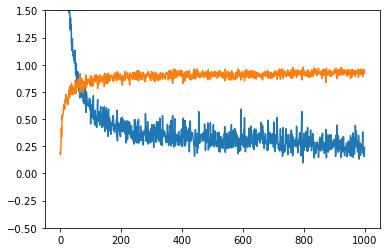

In [239]:
plt.ylim(-0.5, 1.5)
plt.plot(losses)
plt.plot(accuracies)

In [240]:
# Evaluation
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9308

#### NumPy from scratch implementation 

In [355]:
# Weights from pytorch model
l1_weight_torch = model.layer1.weight.detach().numpy().T
l2_weight_torch = model.layer2.weight.detach().numpy().T

# forward pass
def forward(x):
    x = x.dot(l1_weight_torch)
    x = np.maximum(x,0)
    x = x.dot(l2_weight_torch)
    return x

def compare_numpy():
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test == Y_test_preds).mean()

compare_numpy()

0.9308

In [371]:
def forward_and_backward(x, y):
    batch_size = x.shape[0]
    
    # Forward pass
    lay1 = x.dot(weights_l1)
    act = np.maximum(lay1, 0)
    logits = act.dot(weights_l2)
    
    # Calculate loss (broken down into individual steps)
    # https://www.youtube.com/watch?v=q8SA3rM6ckI
    logit_maxes = logits.max(1, keepdims=True)
    norm_logits = logits - logit_maxes # subtract max for numerical stability
    counts = np.exp(norm_logits)
    counts_sum = counts.sum(1, keepdims=True)
    counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
    probs = counts * counts_sum_inv
    logprobs = np.log(probs)
    loss = -logprobs[range(batch_size), y].mean()
    
#     print("logits",logits)
#     print("logit_maxes",logit_maxes)
#     print("norm_logits",norm_logits)
#     print("counts",counts)
#     print("counts_sum",counts_sum)
#     print("probs",probs*100)
#     print("logprobs", logprobs)
#     print("loss", loss)
    
    #For double checking against the PyTorch results
    #print(F.cross_entropy(torch.tensor(logits).squeeze(), torch.tensor(y)))
    
    # More info on propagations in makemore notebook and in youtube link above
    # Backward pass (lots and lots of chain rule dy/dx = dy/du * du/dx)
    dlogprobs = np.zeros_like(logprobs)
    dlogprobs[range(batch_size), y] = -1.0/batch_size
    
    dlogprobs_dprobs = 1.0/probs
    dprobs = dlogprobs * dlogprobs_dprobs
    
    dprobs_dcounts_sum_inv = counts
    dcounts_sum_inv = (dprobs_dcounts_sum_inv * dprobs).sum(1, keepdims=True) # the sum accounts for tensor broadcasting
    
    dcounts_sum_inv_dcounts_sum = -1.0 / (counts_sum ** 2)
    dcounts_sum = dcounts_sum_inv_dcounts_sum * dcounts_sum_inv
    
    dcounts = dprobs * counts_sum_inv
    dcounts += np.ones_like(counts) * dcounts_sum
    
    dcounts_dnorm_logits = np.exp(norm_logits)
    dnorm_logits = dcounts_dnorm_logits * dcounts
    
    dnorm_logits_dlogit_maxes = -1.0
    dlogit_maxes = (dnorm_logits_dlogit_maxes * dnorm_logits).sum(1, keepdims=True)
    
    dlogits = 1.0 * dnorm_logits
    with torch.no_grad():
        dlogit_maxes_dlogits = F.one_hot(torch.tensor(logits).max(1).indices, num_classes=logits.shape[1]).numpy()
    dlogits += dlogit_maxes_dlogits * dlogit_maxes

    # logits = relu @ l2_weight (batch_size, 10)
    # dlogits = (batch_size, 10)
    # act = (batch_size, 64)
    # l2_weight = (64,10)
    dact = dlogits.dot(np.transpose(weights_l2))
    dl2_weight = np.transpose(act).dot(dlogits)
    
    dact_dlay1 = np.ones_like(lay1)
    dact_dlay1[np.where(lay1 < 0)] = 0
    dlay1 = dact_dlay1 * dact
    
    # dlay1 (batch_size,64)
    # x (batch_size, 784)
    # l1_weight (784, 64)
    dx = dlay1.dot(np.transpose(weights_l1))
    dl1_weight = np.transpose(x).dot(dlay1)
    
    return loss, logits, dl1_weight, dl2_weight

# Based on pytorch linear weight init
def layer_init(fan_in, fan_out):
    # Hard-coding gain for relu
    gain = math.sqrt(2.0)
    std = gain / math.sqrt(fan_in)
    bound = math.sqrt(3.0) * std
    weights = np.random.uniform(-bound, bound, (fan_in,fan_out))
    return weights.astype(np.float32)

loss 0.30 accuracy 0.91: 100%|████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 173.95it/s]


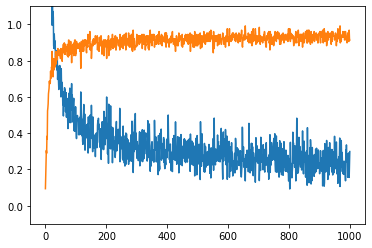

In [380]:
# Init
#np.random.seed(28734)
weights_l1 = layer_init(784, 64)
weights_l2 = layer_init(64, 10)

batch_size = 128
lr = 0.1

losses, accuracies = [], []

for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(batch_size))
    X = X_train[samp].reshape((-1, 784))
    Y = Y_train[samp]
    
    loss, logits, dl1, dl2 = forward_and_backward(X, Y)
    
    cat = np.argmax(logits, axis=1)
    accuracy = (cat == Y).mean()
    
    # SGD
    weights_l1 = weights_l1 - lr*dl1
    weights_l2 = weights_l2 - lr*dl2
    
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
    
plt.ylim(-0.1, 1.1)
plt.plot(losses)
plt.plot(accuracies)

In [381]:
# Evaluation
eval_loss, eval_logits, _, _ = forward_and_backward(X_test.reshape((-1, 784)), Y_test)
eval_cat = np.argmax(eval_logits, axis=1)
eval_accuracy = (eval_cat == Y_test).mean()

print("Eval loss: ", eval_loss)
print("Eval Accuracy: ", eval_accuracy)

Eval loss:  0.23710975642513804
Eval Accuracy:  0.9287


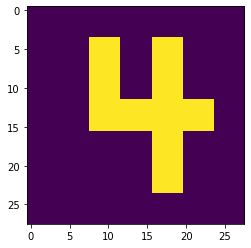

In [383]:
# for fun, can it recognize 4?
m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]
# upscale to 28x28
m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
plt.imshow(m.reshape(28,28))

In [384]:
tst = m.reshape(1, -1).dot(weights_l1)
tst = np.maximum(tst, 0)
tst = tst.dot(weights_l2)
np.argmax(tst)

4

In [385]:
# :) it works